In [1]:
cd ..

/Users/sean/CloudStation/Metis/projects/project4


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib inline

In [3]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

In [4]:
love_snippets.n_love_sents.sum()

3160

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [5]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [6]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [7]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02128323 0.01730485]
3 topics variance ratios: [0.02128322 0.01730638 0.01293763]
4 topics variance ratios: [0.02128322 0.01730696 0.01293715 0.01074324]
5 topics variance ratios: [0.02128322 0.01730638 0.01293573 0.01072854 0.00947157]


# The 2-Topic Result

In [8]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, think, feel, people, say, got, want, like, don, time, life, years


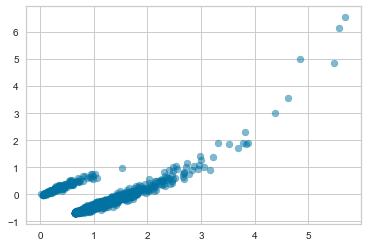

In [9]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

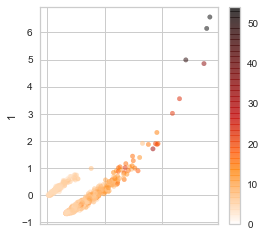

In [10]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents.astype({'n_love_sents':'int32'})+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

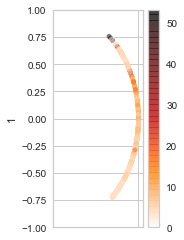

In [11]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

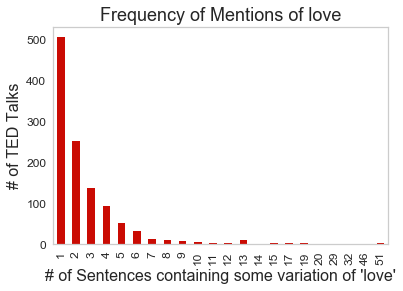

In [12]:
freq=pd.DataFrame(love_snippets.n_love_sents.value_counts()).sort_index()
ax = freq.plot.bar(title="Frequency of Mentions of love",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("# of Sentences containing some variation of 'love'", fontsize=16)
ax.set_ylabel("# of TED Talks", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
fig.savefig('./reports/figures/LoveMentionsInTEDTalks.svg',\
            format='svg', dpi=1200, transparent=True);

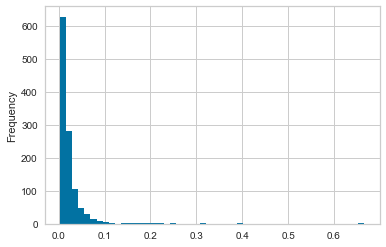

In [13]:
pct = love_snippets.n_love_sents/love_snippets.sentences
pct.plot.hist(bins=50);

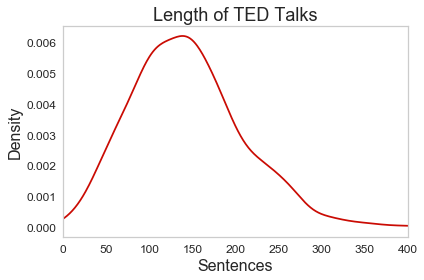

In [14]:
ax = love_snippets.sentences.plot.density(title="Length of TED Talks",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("Sentences", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlim(0,400)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('./reports/figures/TEDTalkLengthDensityPlot.svg',\
            format='svg', dpi=1200, transparent=True);

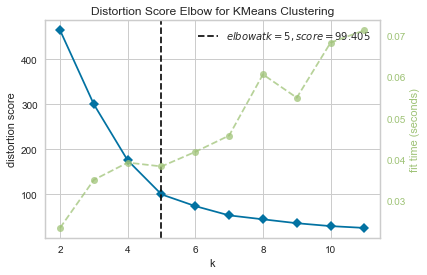

In [15]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [16]:
visualizer.elbow_value_

5

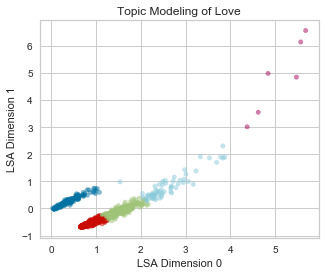

In [17]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [18]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.87313438 -0.54591327]
g [ 1.48143648 -0.13251815]
b [0.38457901 0.25738487]
c [2.58769958 0.80695154]
m [5.09312712 4.85259   ]


In [19]:
love_snippets['cluster']= km.labels_
love_snippets.groupby(['cluster']).mean()

,sentences,n_love_sents
cluster,,
0,142.375209,1.725293
1,153.593960,3.761745
2,129.437500,1.227273
3,164.692308,8.830769
4,171.666667,36.500000


In [20]:
love_snippets[love_snippets['cluster']==2].love

28      Howard's about this high, and he's round, and ...
31      So from that moment on, I read every medical b...
48      (Laughter)If I were in charge of the Internet,...
85      ♫ Strolling along in Central Park ♫♫ Everyone'...
91      I'll get your ex-lover telling someone else, "...
                              ...                        
2411    Many of us have lost family, friends or loved ...
2427    After a brief period of really horrible withdr...
2429    And to top it all off, our videos themselves —...
2432    He loved to recount stories such as how he liv...
2433    And I loved it. And don't get me wrong — somet...
Name: love, Length: 176, dtype: object

Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [21]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.563774,0.171706,1.072342,1.622256,6.317966
1,0.295331,0.440549,0.959574,1.888857,6.568006
2,0.117382,0.852587,0.961778,2.301409,6.966319
3,0.635226,0.109694,1.142372,1.557085,6.265550
4,2.796194,2.066432,2.806656,0.618603,4.152093


Show the snippets from the 4 (euclidean distance) closest documents:

In [22]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313438 -0.54591327] color= r
815 : [ 0.87827331 -0.549379  ] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
990 : [ 0.8676683  -0.53884112] (Laughter)Now, I love this species despite the fact that it tried to kill us, and that's because this species in Madagascar, its closest relatives are 6,000 kilometers away, cavefishes in Australia.
573 : [ 0.86793703 -0.5375245 ] Because probably some of the things that we love most are going to be also the things that can hurt us most.
626 : [ 0.8827676  -0.54229829] Mike deGruy was also invited, and he spoke with great passion about his love of the ocean, and he also talked to me about applying my approach to something he's been involv

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

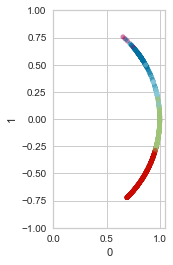

In [23]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [24]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87313438 -0.54591327] color= r
815 : [ 0.87827331 -0.549379  ] His story is the following: He was recruited when he was 17, and sometime later, in his squadron, if you will, this beautiful girl was recruited, and they fell in love. But it turns out that love is very strictly forbidden in the lower ranks of the guerrilla, so their romance was discovered and they were separated. We'd love to help.
641 : [ 0.94666744 -0.5931273 ] It's made into a grade where it's not usable for a nuclear weapon, but they love this stuff. Well, we're securing them, and it would be great if we could burn them, eat them up, and this reactor loves this stuff. So you have what's called the xenon pit, and so some of these fission products love neutrons. They love the neutrons that are going on and helping this reaction take place.
71 : [ 0.89771091 -0.56323847] In the Summer of Love, in 1967, two million people, children, died of smallpox.
734 : [ 0.908143   -0.57017057] Another example

Now clustering on the 

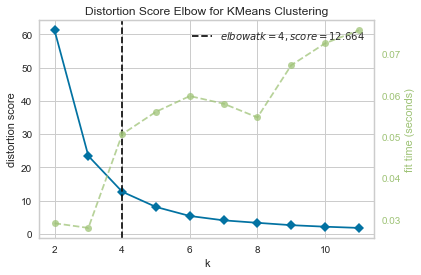

In [25]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

<Figure size 432x288 with 0 Axes>

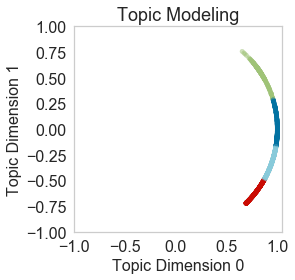

In [26]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

fig = plt.figure() 
ax = df.plot.scatter(x=0,y=1,figsize=(4,4), c=col, alpha = 0.5,title='Topic Modeling',\
                     fontsize=16);
ax.title.set_size(18)
ax.set_xlabel("Topic Dimension 0", fontsize=16)
ax.set_ylabel("Topic Dimension 1", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
plt.axis([-1,1.05,-1,1]);
plt.savefig("reports/figures/CV_binary-lsa_2topic.svg",\
            format='svg', dpi=1200, transparent=True)

In [27]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.77493381 -0.62553867] color= r
401 : [ 0.77825687 -0.62794606] And I would love for CEG to help make it happen.
611 : [ 0.77791126 -0.62837415] Most of all, I learned about love. Martha Gellhorn, who's one of my heroes, once said, "You can only love one war.
765 : [ 0.7776964  -0.62864005] I really love them.
1054 : [ 0.77887549 -0.62717858] The thrill of archaeological discovery is as powerful as love, because ancient history is the most seductive mistress imaginable. I love what I do, because I learn that we haven't changed. (Arabic) Omer by brother, I will always love you. (English) Omer my brother, I will always love you.


Cluster centered at: [0.83568725 0.53776918] color= g
322 : [0.84104294 0.54096837] We wondered: does this have an effect on how the parents cope with the loss of their loved one?
398 : [0.84116391 0.54078024] As a boy, I loved cars.
614 : [0.84154999 0.54017925] (Typing) And then once she found out when Mother's Day was happening, she d

# The 3-Topic Result

In [28]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, person, just, think, feel, people, say, got, want, like, don, time, years, life

Topic  2
love, think, want, study, thinking, lot, romantic, brain, ve, work, little, world, single, know


In [29]:
cv_doc_topic[1]

array([[ 1.33989859, -0.22925595, -0.65805825],
       [ 1.11048993, -0.37172955,  0.11805285],
       [ 0.78114606, -0.61732741,  0.19094439],
       ...,
       [ 0.74191762, -0.62485586,  0.16260277],
       [ 1.13037887, -0.5709889 ,  0.158482  ],
       [ 0.87370674, -0.57889066,  0.04410868]])

In [30]:
from mpl_toolkits.mplot3d import Axes3D

In [31]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

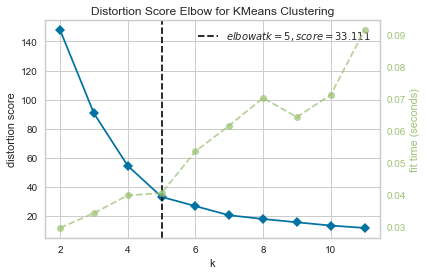

In [32]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [33]:
num_clusters = 4 #visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

You may have to execute this cell 3 times:

<IPython.core.display.Javascript object>


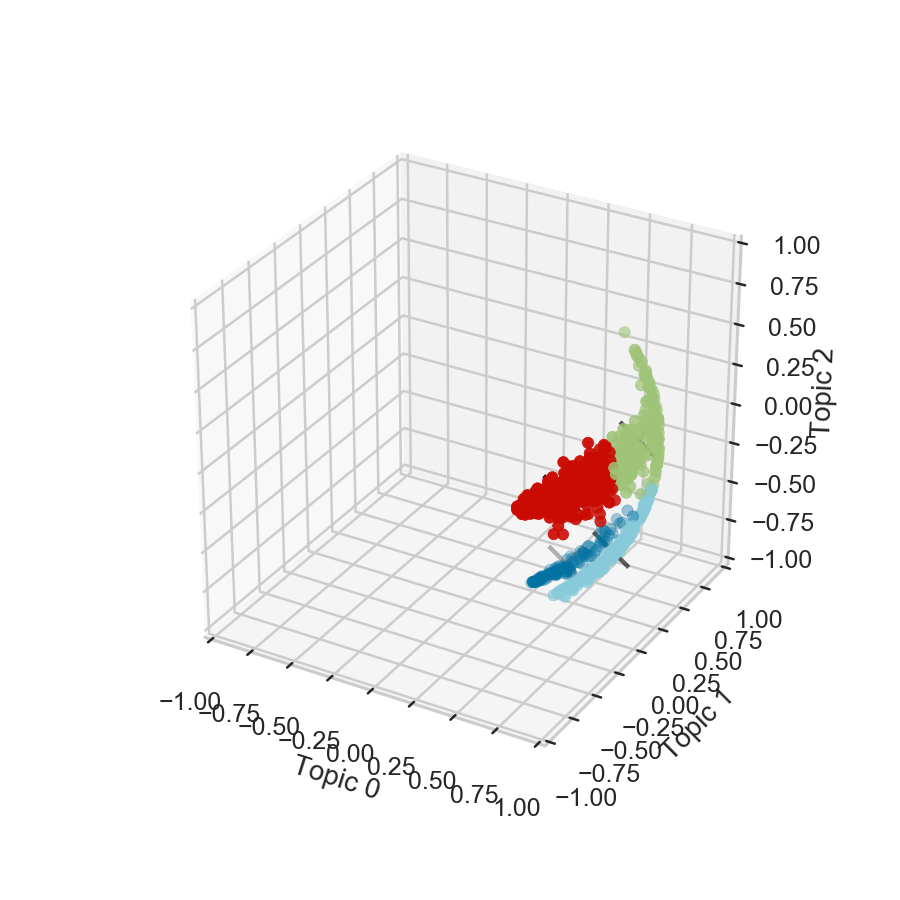

In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=200,c='k')
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [37]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.82623891 -0.5076374   0.16162915] color= r
204 : [ 0.83986547 -0.51740156  0.16407808] We're all going to eventually, even in the developed world, going to have to lose everything that we love.
583 : [ 0.83882023 -0.51660663  0.17175044] Now, I would love to tell you that the fact that the open-source programmers have worked out a collaborative method that is large scale, distributed, cheap, and in sync with the ideals of democracy, I would love to tell you that because those tools are in place, the innovation is inevitable.
808 : [ 0.84110333 -0.51263506  0.17248329] He said, "You know, everybody here would pretty much love  to have their houses plastered and painted.
626 : [ 0.83939508 -0.51471142  0.17460831] Mike deGruy was also invited, and he spoke with great passion about his love of the ocean, and he also talked to me about applying my approach to something he's been involved with for a very long time, which is the hunt for the giant squid.


Cluster ce

# The 4-Topic Result

In [38]:
display_topics(cv_lsa[2], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, person, just, feel, think, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, lot, romantic, brain, ve, work, little, world, single, partner

Topic  3
loved, love, fell, doing, idea, thought, didn, great, times, instead, ideas, version, experiences, generous


In [39]:
doc_topic = cv_doc_topic[2]
df = pd.DataFrame(normalize(cv_doc_topic[2]))

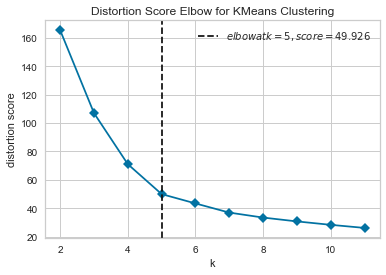

In [40]:
%matplotlib inline
fig, ax = plt.subplots()
km=KMeans()
visualizer = KElbowVisualizer(km, ax=ax, k=(2,12),metric='distortion',\
                              timings=False)  #,title='for KMeans Clustering')
visualizer.fit(df)                     # Fit the data to the visualizer
# fig.suptitle('Distortion Score Elbow', fontsize=18)
# ax.set_xlabel('k',fontsize=16)
# ax.set_ylabel('Distortion Score',fontsize=16)
visualizer.show(outpath='./reports/figures/cv_binary_lsa_4Elbow.svg',dpi=1200);                     # Finalize and render the figure

In [41]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


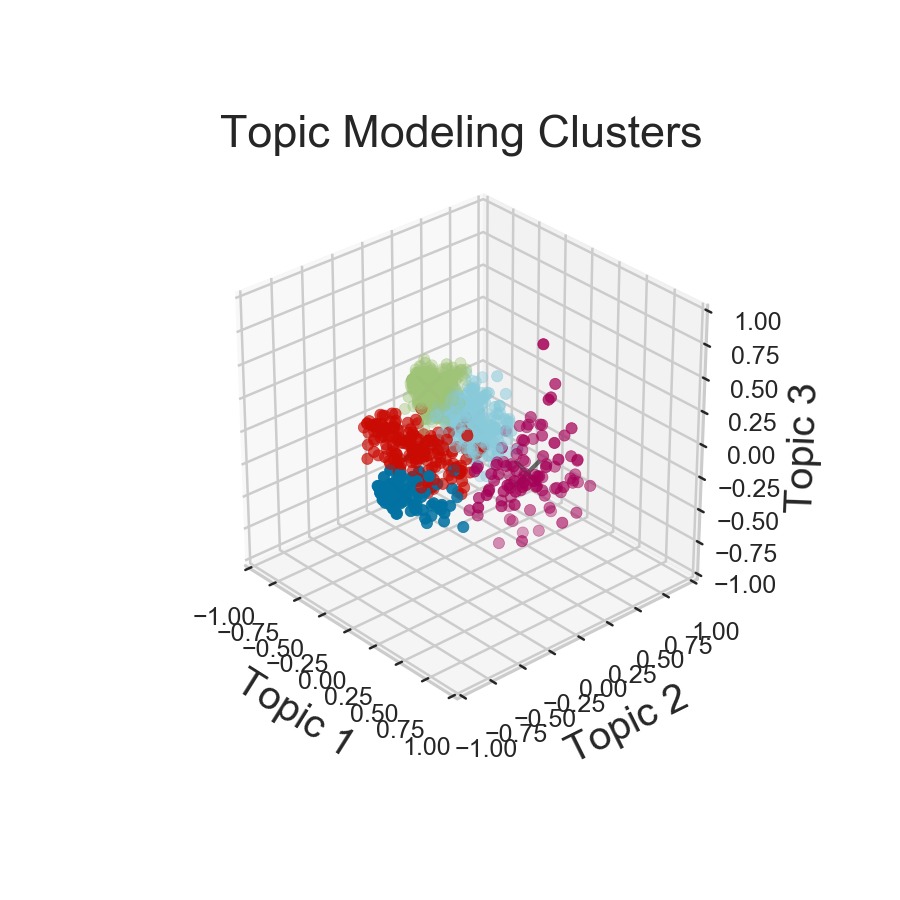

In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) # .gca(projection='3d')
ax = fig.add_subplot(111, projection='3d',\
                     title="Topic Modeling Clusters")
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.title.set_size(18)
# The newlines in front of the labels make it so they are better spaced
# from the axis:
# source: https://stackoverflow.com/questions/5525782/adjust-label-positioning-in-axes3d-of-matplotlib
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(elev=15, azim=-45)
ax.dist = 12
fig.show()
fig.savefig('./reports/figures/cv_binary-lsa_4topic.svg',\
            format='svg', dpi=1200, transparent=True);

In [ ]:
# Set up formatting for the movie files
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/ffmpeg/4.2.1_2/bin/ffmpeg'
Writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Sean Davern'),\
                                bitrate=-1, extra_args=['-vcodec','libx264'])

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, title="Topic Modeling Clusters")
ax.title.set_size(18)
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
# Create an init function and the animate functions.
# Both are explained in the tutorial:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
# Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function.
def init():
    ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
    ax.scatter(df[1],df[2],df[3],c=col)
    ax.dist = 12
    return fig,

def animate(i):
    ax.view_init(elev=15+i, azim=-45)
    ax.dist = 12
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=75, interval=1, blit=True,
                               repeat=False)
# Save
anim.save('./reports/figures/cv_binary-lsa_animation.mp4',\
          writer = Writer, dpi=600)

In [ ]:
doc_topic = cv_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')